In [1]:
import cv2
import torch
from tensorboardX import SummaryWriter
import h5py
import numpy as np
import imageio
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import time
from collections import defaultdict

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0) # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

/home/rook/.local/share/virtualenvs/sketch2code-rS5pvLAN/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
%reload_ext autoreload

from sketch2code.data_model import *
from sketch2code.datasets import *
from sketch2code.helpers import *
from sketch2code.synthesize_program import *
from sketch2code.visualization import *
from s2x_rl_dqn import *
from s20_rl_dqn import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#examples 1750
#examples 1250
#examples 250
#examples 250


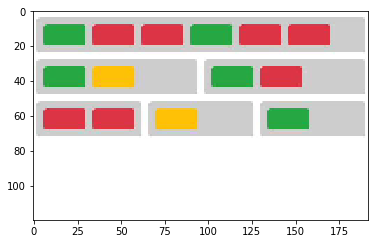

In [4]:
tags, oimages = load_dataset("toy")
print("#examples", len(tags))

def preprocess_img():
    global oimages
    return [shrink_img(img, 0.4, cv2.INTER_NEAREST) for img in norm_rgb_imgs(oimages[:])]

images = cache_object("toy.shrink.imgs.without_transpose", preprocess_img)
plt.imshow(1 - images[0])

vocab, ivocab = make_toy_vocab_v1()
train_examples, valid_examples, test_examples = get_toy_dataset_v1(tags, vocab)

In [5]:
render_engine = RemoteRenderEngine.get_instance(tags[0].to_html(), viewport_width=oimages[0].shape[1], viewport_height=oimages[0].shape[0], full_page=False)

In [6]:
# TODO: uncomment to use GPU
# images = torch.tensor(images, device=device)
torch_images = torch.tensor(images).permute((0, 3, 1, 2))

In [7]:
env_creator = EnvCreator(render_engine, tags, vocab, images, shrink_factor=0.4, interpolation=cv2.INTER_NEAREST, device=device)

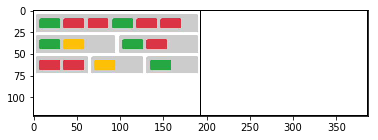

In [8]:
envs = [Env(env_creator, 0)]
plt.imshow(1 - envs[0].render())

In [9]:
env = envs[0]
reward_func = RewardFunc(env.get_target_state())
env.set_reward_func(reward_func.reward, reward_func.max_reward)

In [10]:
env.__dict__

{'env_creator': <s2x_rl_dqn.EnvCreator at 0x7fa489dc6c18>,
 'env_idx': 0,
 'obs': <s2x_rl_dqn.Observation at 0x7fa489db4c88>,
 'abs_reward': 0,
 'max_abs_reward': 14208,
 'reward_func': <bound method RewardFunc.reward of <s20_rl_dqn.RewardFunc object at 0x7fa4834c4710>>,
 'invalid_action_penalty': -10}

# Train DQN

In [11]:
g = Placeholder()
g.MAX_EPS_LEN = 10

g.BATCH_SIZE = 50
g.GAMMA = 0.999
g.EPS_START = 0.9
g.EPS_END = 0.05
g.EPS_DECAY = 10000
g.TARGET_UPDATE = 10  # per eps
g.POLICY_UPDATE = 10  # per actions

g.IMG_REPR_SIZE = 512
g.DSL_EMBED_DIM = 100
g.DSL_HIDDEN_DIM = 512

g.dsl_vocab = env_creator.vocab
g.n_actions = len(env_creator.actions)
print("n_action:", g.n_actions, ", |dsl_vocab|:", len(g.dsl_vocab))

n_action: 12 , |dsl_vocab|: 15


In [31]:
policy_q = DQN(
    EncoderV1(img_h=images[0].shape[0], img_w=images[0].shape[1], img_repr_size=g.IMG_REPR_SIZE), 
    ActionDecoder(g.IMG_REPR_SIZE, dsl_vocab=vocab, dsl_embedding_dim=g.DSL_EMBED_DIM, dsl_hidden_dim=g.DSL_HIDDEN_DIM, n_actions=g.n_actions)).to(device)
target_q = DQN(
    EncoderV1(img_h=images[0].shape[0], img_w=images[0].shape[1], img_repr_size=g.IMG_REPR_SIZE), 
    ActionDecoder(g.IMG_REPR_SIZE, dsl_vocab=vocab, dsl_embedding_dim=g.DSL_EMBED_DIM, dsl_hidden_dim=g.DSL_HIDDEN_DIM, n_actions=g.n_actions)).to(device)
target_q.load_state_dict(policy_q.state_dict())
target_q.eval()

DQN(
  (encoder): EncoderV1(
    (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=12160, out_features=512, bias=True)
  )
  (decoder): ActionDecoder(
    (word_embedding): Embedding(15, 100, padding_idx=0)
    (lstm): LSTMNoEmbedding(
      (lstm): LSTM(612, 512, batch_first=True)
    )
    (lstm2

In [33]:
optimizer = torch.optim.RMSprop(policy_q.parameters())
memory = ReplayMemory(50)

g.step_done = 0
num_episodes = 10
accum_rewards = []
accum_done = []

log_dir = inc_folder_no(ROOT_DIR / "runs" / "s20_exp" / "run_")
writer = SummaryWriter(log_dir=log_dir)


with tqdm(range(num_episodes), desc='eps') as ebar, tqdm(total=num_episodes * g.MAX_EPS_LEN, desc='actions') as pbar:
    for i_episode in ebar:
        # Initialize the environment and state
        env.reset()
        accum_rewards.append([])

        for i in range(g.MAX_EPS_LEN):
            pbar.update()
            obs = env.obs
            action = select_action(policy_q, env_creator, obs, torch_images, g, device)
            next_obs, reward, done, _ = env.step(action)    

            accum_rewards[-1].append(reward)
            
            # Store the transition in memory
            memory.push(Transition(env.env_idx, obs, next_obs, action.action_id, env.abs_reward, reward, int(done)))
            # Perform one step of the optimization (on the target network)
            
            if len(memory) >= g.BATCH_SIZE:
                loss = train(policy_q, target_q, F.smooth_l1_loss, optimizer, env_creator, memory.sample(g.BATCH_SIZE), torch_images, g, device)
            
            if len(memory) == memory.capacity:
                break
                
            if done:
                break
        
        if len(memory.memory) == memory.capacity:
            break
        
        writer.add_scalar('avg_eps_reward', np.mean(accum_rewards[-1]), i_episode)
        accum_done.append(done)
        ebar.set_postfix(avg_gain=np.mean(accum_rewards[-1]), reward=env.abs_reward)

        # Update the target network, copying all weights and biases in DQN
        if i_episode % g.TARGET_UPDATE == 0:
            target_q.load_state_dict(policy_q.state_dict())
            
writer.close()

In [325]:
memory = ReplayMemory(500)

In [24]:
total_reward = sum([x.abs_reward for x in memory.memory])
idx = np.random.choice(range(len(memory.memory)), 5, replace=False, p=[x.abs_reward / total_reward for x in memory.memory])
batches = [memory.memory[i] for i in idx]

[(i, p.abs_reward, p.reward, list(p.next_state.tag.str_tokens)) for i, p in enumerate(batches)]

[(0,
  0.361768018018018,
  0.361768018018018,
  ['<button class="btn btn-danger">']),
 (1,
  0.3216497747747748,
  0.0,
  ['<div class="col-4">',
   '<div class="col-6">',
   '<div class="col-12">',
   '<button class="btn btn-success">',
   '<div class="col-3">',
   '<button class="btn btn-danger">']),
 (2,
  0.361768018018018,
  0.0,
  ['<button class="btn btn-danger">', '<div class="grey-background">']),
 (3,
  0.3216497747747748,
  0.0,
  ['<div class="col-4">',
   '<div class="col-6">',
   '<div class="col-12">',
   '<button class="btn btn-success">',
   '<div class="col-3">']),
 (4,
  0.1710304054054054,
  -0.15484234234234232,
  ['<div class="col-4">',
   '<button class="btn btn-danger">',
   '</button>',
   '<button class="btn btn-danger">'])]

In [19]:
[(i, p.abs_reward, p.reward, list(p.next_state.tag.str_tokens)) for i, p in enumerate(memory.memory)]

[(0, 0.0, 0.0, ['<div class="col-4">']),
 (1, 0.0, 0.0, ['<div class="col-4">', '<div class="col-6">']),
 (2,
  0.0,
  0.0,
  ['<div class="col-4">', '<div class="col-6">', '<div class="col-12">']),
 (3,
  0.3216497747747748,
  0.3216497747747748,
  ['<div class="col-4">',
   '<div class="col-6">',
   '<div class="col-12">',
   '<button class="btn btn-success">']),
 (4,
  0.3216497747747748,
  0.0,
  ['<div class="col-4">',
   '<div class="col-6">',
   '<div class="col-12">',
   '<button class="btn btn-success">',
   '<div class="col-3">']),
 (5,
  0.3216497747747748,
  0.0,
  ['<div class="col-4">',
   '<div class="col-6">',
   '<div class="col-12">',
   '<button class="btn btn-success">',
   '<div class="col-3">',
   '<button class="btn btn-danger">']),
 (6,
  0.3216497747747748,
  0.0,
  ['<div class="col-4">',
   '<div class="col-6">',
   '<div class="col-12">',
   '<button class="btn btn-success">',
   '<div class="col-3">']),
 (7,
  0.3216497747747748,
  0.0,
  ['<div class="col-

In [34]:
bexamples = memory.sample(g.BATCH_SIZE)

In [39]:
policy_q = DQN(
    EncoderV1(img_h=images[0].shape[0], img_w=images[0].shape[1], img_repr_size=g.IMG_REPR_SIZE), 
    ActionDecoder(g.IMG_REPR_SIZE, dsl_vocab=vocab, dsl_embedding_dim=g.DSL_EMBED_DIM, dsl_hidden_dim=g.DSL_HIDDEN_DIM, n_actions=g.n_actions)).to(device)
target_q = DQN(
    EncoderV1(img_h=images[0].shape[0], img_w=images[0].shape[1], img_repr_size=g.IMG_REPR_SIZE), 
    ActionDecoder(g.IMG_REPR_SIZE, dsl_vocab=vocab, dsl_embedding_dim=g.DSL_EMBED_DIM, dsl_hidden_dim=g.DSL_HIDDEN_DIM, n_actions=g.n_actions)).to(device)
target_q.load_state_dict(policy_q.state_dict())
target_q.eval()

DQN(
  (encoder): EncoderV1(
    (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=12160, out_features=512, bias=True)
  )
  (decoder): ActionDecoder(
    (word_embedding): Embedding(15, 100, padding_idx=0)
    (lstm): LSTMNoEmbedding(
      (lstm): LSTM(612, 512, batch_first=True)
    )
    (lstm2

In [37]:
def report_wg(model):
    grads, weights = 0.0, 0.0
    for p in model.parameters():
        if p.grad is not None:
            grads += p.grad.sum().item()
        weights += p.sum().item()
    return grads, weights

In [38]:
policy_q.train()
optimizer = torch.optim.RMSprop(policy_q.parameters(), lr=5e-4)
losses = []
for i in range(100):
    x = train(policy_q, target_q, F.smooth_l1_loss, optimizer, env_creator, bexamples[:5], torch_images, g, device)
    print(f"{x:.10f}", 'target', report_wg(target_q), 'policy', report_wg(policy_q))
    losses.append(x)
    
    if i % 3 == 0:
        target_q.load_state_dict(policy_q.state_dict())

0.0338697657 target (0.0, 39.06810339912772) policy (-7.717470888915614, 25.384707901626825)
0.8396993876 target (0.0, 25.384707901626825) policy (4.382002294777749, 488.09840572811663)
0.2399831116 target (0.0, 25.384707901626825) policy (-43.14442219976951, 592.6080336337909)
0.0467058420 target (0.0, 25.384707901626825) policy (-17.59756847360842, 681.7979613877833)
0.5620483160 target (0.0, 681.7979613877833) policy (-23.326732020799, 650.9129146616906)
0.6664702892 target (0.0, 681.7979613877833) policy (-410.49753265894105, 1247.7293339157477)
0.2013376206 target (0.0, 681.7979613877833) policy (240.26189744952944, 1216.6608694717288)
0.2736930549 target (0.0, 1216.6608694717288) policy (-118.49623791862541, 1249.0392784383148)
0.0106074642 target (0.0, 1216.6608694717288) policy (7.39627484996069, 1266.466352316551)
0.0036621280 target (0.0, 1216.6608694717288) policy (-3.2444191765288153, 1251.3169315420091)
0.0950069055 target (0.0, 1251.3169315420091) policy (3.37327568748923

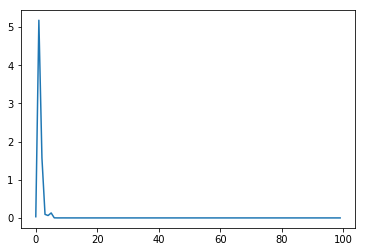

In [280]:
plt.plot(losses)

In [40]:
policy_q.train()
optimizer = torch.optim.RMSprop(policy_q.parameters(), lr=5e-4)
with tqdm(range(100)) as pbar:
    for i in pbar:
        avg_loss = []
        for j in range(5):
            loss = train(policy_q, target_q, F.smooth_l1_loss, optimizer, env_creator, bexamples, torch_images, g, device)
            avg_loss.append(float(loss))
        
        pbar.set_postfix(loss=np.mean(avg_loss))
        if i % 3 == 0:
            target_q.load_state_dict(policy_q.state_dict())

In [46]:
g.step_done

100

In [15]:
g.EPS_END + (g.EPS_START - g.EPS_END) * math.exp(-1 * g.step_done / g.EPS_DECAY)

0.2799671216792575

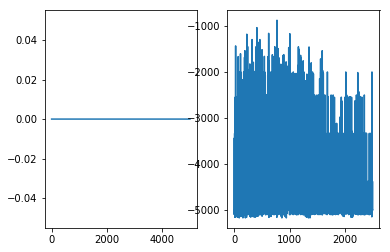

In [16]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(accum_done)
mean_rewards = [np.mean(values) for values in accum_rewards]
ax[1].plot(mean_rewards[::2])
plt.show()

In [15]:
[(i, x) for i, x in enumerate(mean_rewards) if x > 0]

[]

#### Evaluate the model

take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000


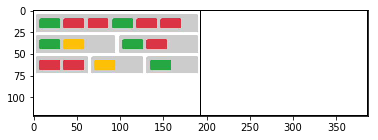

In [22]:
env.reset()
for i in range(g.MAX_EPS_LEN):
    action = select_action(policy_q, env_creator, env.obs, g, device, eps_threshold=0.05)
    next_obs, reward, _, _ = env.step(action)
    print('take action:', action, 'reward', reward)
    if i > 20:
        break
plt.imshow(1 - env.render())

### Debug zone

Test if the train function is executed as expected (they involve sorting so we need to double check the index

00 Undo()
01 AddCloseTag()
02 AddOpenTagAndClass(<div class="row">)
03 AddOpenTagAndClass(<div class="col-12">)
04 AddOpenTagAndClass(<div class="col-6">)
05 AddOpenTagAndClass(<div class="col-4">)
06 AddOpenTagAndClass(<div class="col-3">)
07 AddOpenTagAndClass(<div class="container-fluid">)
08 AddOpenTagAndClass(<div class="grey-background">)
09 AddOpenTagAndClass(<button class="btn btn-danger">)
10 AddOpenTagAndClass(<button class="btn btn-warning">)
11 AddOpenTagAndClass(<button class="btn btn-success">)


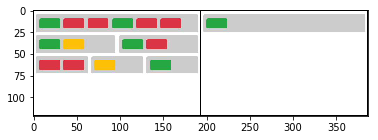

In [31]:
for i, a in enumerate(env_creator.actions):
    print(f"{i:02}", a)
plt.imshow(1 - env.render())

curr_obs pvector(['<div class="container-fluid">', '<div class="row">', '<div class="col-12">']) action AddOpenTagAndClass(<div class="grey-background">) reward=1363.0 done=False
<div class="container-fluid"><div class="row"><div class="col-12"><div class="grey-background"></div></div></div></div>


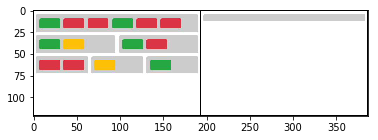

In [47]:
def create_transition(env, actions):
    env.reset()
    for a in actions:
        obs = env.obs
        a = env_creator.actions[a]
        next_obs, reward, done, _ = env.step(a)
    
    print('curr_obs', obs.tag.str_tokens, 'action', a, f'reward={reward}', f'done={done}')
    return Transition(env.env_idx, obs, next_obs, a.action_id, reward, done)

t0 = create_transition(env, [7, 2, 3, 8])
print(t0.next_state.tag.to_body())
plt.imshow(1- env.render(t0.next_state))

In [48]:
batch1 = [create_transition(env, [7, 2, 3, 8])]
batch2 = batch1 + [create_transition(env, [7, 2, 3, 8, 11])]
batch3 = batch1 + [create_transition(env, [7, 2, 3, 8, 0])]

curr_obs pvector(['<div class="container-fluid">', '<div class="row">', '<div class="col-12">']) action AddOpenTagAndClass(<div class="grey-background">) reward=1363.0 done=False
curr_obs pvector(['<div class="container-fluid">', '<div class="row">', '<div class="col-12">', '<div class="grey-background">']) action AddOpenTagAndClass(<button class="btn btn-success">) reward=608.0 done=False
curr_obs pvector(['<div class="container-fluid">', '<div class="row">', '<div class="col-12">', '<div class="grey-background">']) action Undo() reward=-1363.0 done=False


In [99]:
optimizer = torch.optim.RMSprop(policy_q.parameters())
train(policy_q, target_q, F.smooth_l1_loss, optimizer, env_creator, batch1, torch_images, g, device)

>> curr tensor([0], device='cuda:0') 
 tensor([[8]], device='cuda:0') 
 tensor([[-1.3245]], device='cuda:0', grad_fn=<GatherBackward>)
>> next tensor([0], device='cuda:0') 
 tensor([[-2.4218, -2.5405, -2.4874, -2.4078, -2.4841, -2.4470, -2.4657, -2.5869,
         -2.5167, -2.4995, -2.4962, -2.4785]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>) 
 tensor([-2.4078], device='cuda:0')
reorder_obs_action_values tensor([[-1.3245]], device='cuda:0', grad_fn=<IndexPutBackward>)
reordered_expected_obs_action_values tensor([[1360.5946]], device='cuda:0')


1361.419189453125

In [102]:
optimizer = torch.optim.RMSprop(policy_q.parameters())
train(policy_q, target_q, F.smooth_l1_loss, optimizer, env_creator, batch2, torch_images, g, device)

>> curr tensor([1, 0], device='cuda:0') 
 tensor([[11],
        [ 8]], device='cuda:0') 
 tensor([[-0.3091],
        [-1.3245]], device='cuda:0', grad_fn=<GatherBackward>)
>> next tensor([1, 0], device='cuda:0') 
 tensor([[-2.4504, -2.4976, -2.4923, -2.3906, -2.5131, -2.4852, -2.5151, -2.4784,
         -2.4852, -2.5037, -2.5056, -2.5087],
        [-2.4218, -2.5405, -2.4874, -2.4078, -2.4841, -2.4470, -2.4657, -2.5869,
         -2.5167, -2.4995, -2.4962, -2.4785]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>) 
 tensor([-2.3906, -2.4078], device='cuda:0')
reorder_obs_action_values tensor([[-1.3245],
        [-0.3091]], device='cuda:0', grad_fn=<IndexPutBackward>)
reordered_expected_obs_action_values tensor([[1360.5946],
        [ 605.6118]], device='cuda:0')


983.4200439453125

In [103]:
optimizer = torch.optim.RMSprop(policy_q.parameters())
train(policy_q, target_q, F.smooth_l1_loss, optimizer, env_creator, batch3, torch_images, g, device)

>> curr tensor([1, 0], device='cuda:0') 
 tensor([[0],
        [8]], device='cuda:0') 
 tensor([[-24.0616],
        [ -1.3245]], device='cuda:0', grad_fn=<GatherBackward>)
>> next tensor([0, 1], device='cuda:0') 
 tensor([[-2.4218, -2.5405, -2.4874, -2.4078, -2.4841, -2.4470, -2.4657, -2.5869,
         -2.5167, -2.4995, -2.4962, -2.4785],
        [-2.4550, -2.5585, -2.4973, -2.4773, -2.4607, -2.4369, -2.4830, -2.5647,
         -2.5090, -2.4641, -2.4985, -2.4242]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>) 
 tensor([-2.4078, -2.4242], device='cuda:0')
reorder_obs_action_values tensor([[ -1.3245],
        [-24.0616]], device='cuda:0', grad_fn=<IndexPutBackward>)
reordered_expected_obs_action_values tensor([[ 1360.5946],
        [-1365.4218]], device='cuda:0')


1351.1396484375

In [54]:
env.reset()

In [19]:
action = select_action(policy_q, env_creator, env.obs, g, device)
print(action)
print(env.step(action)[0].curr_tag.to_body())

AddOpenTag(<div>)
<div></div>


In [ ]:
plt.imshow(1 - env.render())

In [ ]:
print(env.obs.curr_tag.to_body())
print(env.obs.curr_tag.str_tokens)
print(env.obs.curr_tag.tokens)